lstm4

결과요약: RMSE: 23.384016036987305  이상점 제거 하+normalize 안함

개인적으로 이상점을 제거한 후 normalize를 하면 rmse가 커질 수 밖에 없다고 생각함. 다음시도(lstm3)은 이상점을 제거하지 않고 normalize를 하고, lstm4에서는 이상점을 제거하고 normalize를 하지 않는 것을 시도하겠다.

Data import

시도 내용 요약:
주중(1)/주말(2) + 겨울(1)봄(2)여름(3)가을(4) // 

이미 lstm이라는 것이 sequence 개념이 있으므로 시간축(1~397)를 feature로 설정하는 것은 의미가 없을 듯 하여 LSTM 시도2에서는 제외함

https://bigdatascientistblog.wordpress.com/2015/10/02/feature-engineering-with-dates-part-1/

에 따르면 날짜 datestampe에서 9가지의 특성을 끌어낼 수 있다고 한다. 따라서 이를 적용해보고자 한다.

year, month, day, day of week, week of year, hour of day

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
tf.set_random_seed(7)


In [2]:
columns=['date','sales']

txs=pd.read_table('./lstmData/lstmPrac2.csv', sep=',',header=None,names=columns )
txs.info()
txs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
date     397 non-null object
sales    397 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.3+ KB


,date,sales
0,2016-01-01,34
1,2016-01-02,41
2,2016-01-03,54
3,2016-01-04,41
4,2016-01-05,35


In [3]:
from datetime import datetime                    

# 1. 기본 feature

In [4]:
year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year  
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
# please read docs on how week numbers are calculate
week_number = lambda x: datetime.strptime(x, "%Y-%m-%d" ).strftime('%V')

# 2. 추가 feature

In [5]:
seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d" ).month-1)]

In [6]:
txs['year'] = txs['date'].map(year)
txs['month']=txs['date'].map(month)
txs['week_number']=txs['date'].map(week_number)
txs['season']=txs['date'].map(season)
txs['day_of_week']=txs['date'].map(day_of_week)
# txs['week_number']=txs['date'].map(week_number)
txs

,date,sales,year,month,week_number,season,day_of_week
0,2016-01-01,34,2016,1,53,0,4
1,2016-01-02,41,2016,1,53,0,5
2,2016-01-03,54,2016,1,53,0,6
3,2016-01-04,41,2016,1,01,0,0
4,2016-01-05,35,2016,1,01,0,1
5,2016-01-06,44,2016,1,01,0,2
6,2016-01-07,50,2016,1,01,0,3
7,2016-01-08,42,2016,1,01,0,4
8,2016-01-09,42,2016,1,01,0,5
9,2016-01-10,66,2016,1,01,0,6


pandas를 통해 구한 각 feature는 list()로 우리의 기준type인 list로 변경이 가능

# 3. 추가 가공

## 이상점 제거

normalization, bucketization 을 하여 새로운 열을 생성하는 방향으로

이상점 제거를 위해 평균과 표준편차를 구한다. 이상점의 기준은 일단 평균+-2*sd로 설정

In [7]:
xySales=txs['sales']

In [8]:
xySales=list(xySales)

In [9]:
mean=np.mean(xySales)
mean

35.191435768261968

In [10]:
std=np.std(xySales)
std

36.518152240039889

In [11]:
for i in range(len(xySales)):
    if (xySales[i]<mean-2*std or xySales[i]>mean+2*std):
         xySales[i]=int(mean)
        

In [12]:
xySales

[34,
 41,
 54,
 41,
 35,
 44,
 50,
 42,
 42,
 66,
 50,
 55,
 56,
 53,
 44,
 54,
 54,
 50,
 40,
 49,
 28,
 72,
 71,
 53,
 43,
 38,
 55,
 49,
 43,
 49,
 49,
 44,
 39,
 52,
 45,
 33,
 43,
 40,
 46,
 49,
 50,
 37,
 37,
 45,
 48,
 48,
 38,
 60,
 31,
 35,
 53,
 70,
 62,
 48,
 51,
 49,
 38,
 32,
 39,
 35,
 30,
 36,
 31,
 31,
 44,
 41,
 41,
 45,
 46,
 45,
 41,
 47,
 48,
 40,
 42,
 38,
 38,
 45,
 48,
 62,
 46,
 38,
 62,
 81,
 40,
 45,
 42,
 53,
 53,
 56,
 53,
 47,
 61,
 64,
 62,
 37,
 65,
 54,
 44,
 46,
 50,
 43,
 53,
 63,
 52,
 2,
 0,
 0,
 72,
 59,
 75,
 47,
 44,
 77,
 90,
 93,
 47,
 61,
 77,
 35,
 50,
 58,
 33,
 41,
 36,
 64,
 49,
 53,
 60,
 43,
 41,
 55,
 45,
 18,
 60,
 69,
 54,
 39,
 50,
 44,
 54,
 57,
 82,
 57,
 44,
 56,
 51,
 55,
 28,
 56,
 54,
 36,
 12,
 25,
 41,
 11,
 6,
 9,
 35,
 29,
 24,
 23,
 14,
 21,
 20,
 25,
 23,
 27,
 31,
 16,
 14,
 30,
 32,
 75,
 35,
 26,
 12,
 21,
 23,
 28,
 25,
 31,
 21,
 17,
 10,
 29,
 34,
 28,
 20,
 36,
 23,
 15,
 42,
 28,
 24,
 29,
 20,
 14,
 18,
 27,
 22,


## Normalization

lstm4에서는 생략

## 합쳐서 최종 input XY생성

In [13]:
tempxy=[list(txs['season']),list(txs['day_of_week']),list(txs['week_number']),xySales]

In [14]:
tempxy

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,


In [15]:
xy=np.array(tempxy)

In [16]:
xy

array([['0', '0', '0', ..., '0', '0', '0'],
       ['4', '5', '6', ..., '6', '0', '1'],
       ['53', '53', '53', ..., '04', '05', '05'],
       ['34', '41', '54', ..., '0', '5', '31']], 
      dtype='<U21')

In [17]:
temp=xy.transpose()

In [18]:
temp

array([['0', '4', '53', '34'],
       ['0', '5', '53', '41'],
       ['0', '6', '53', '54'],
       ..., 
       ['0', '6', '04', '0'],
       ['0', '0', '05', '5'],
       ['0', '1', '05', '31']], 
      dtype='<U21')

In [19]:
xy = temp.astype(np.float)

In [20]:
xy

array([[  0.,   4.,  53.,  34.],
       [  0.,   5.,  53.,  41.],
       [  0.,   6.,  53.,  54.],
       ..., 
       [  0.,   6.,   4.,   0.],
       [  0.,   0.,   5.,   5.],
       [  0.,   1.,   5.,  31.]])

[[  0.   4.  53.  34.]
 [  0.   5.  53.  41.]
 [  0.   6.  53.  54.]
 [  0.   0.   1.  41.]
 [  0.   1.   1.  35.]
 [  0.   2.   1.  44.]
 [  0.   3.   1.  50.]] -> [ 42.]
[[  0.   5.  53.  41.]
 [  0.   6.  53.  54.]
 [  0.   0.   1.  41.]
 [  0.   1.   1.  35.]
 [  0.   2.   1.  44.]
 [  0.   3.   1.  50.]
 [  0.   4.   1.  42.]] -> [ 42.]
[[  0.   6.  53.  54.]
 [  0.   0.   1.  41.]
 [  0.   1.   1.  35.]
 [  0.   2.   1.  44.]
 [  0.   3.   1.  50.]
 [  0.   4.   1.  42.]
 [  0.   5.   1.  42.]] -> [ 66.]
[[  0.   0.   1.  41.]
 [  0.   1.   1.  35.]
 [  0.   2.   1.  44.]
 [  0.   3.   1.  50.]
 [  0.   4.   1.  42.]
 [  0.   5.   1.  42.]
 [  0.   6.   1.  66.]] -> [ 50.]
[[  0.   1.   1.  35.]
 [  0.   2.   1.  44.]
 [  0.   3.   1.  50.]
 [  0.   4.   1.  42.]
 [  0.   5.   1.  42.]
 [  0.   6.   1.  66.]
 [  0.   0.   2.  50.]] -> [ 55.]
[[  0.   2.   1.  44.]
 [  0.   3.   1.  50.]
 [  0.   4.   1.  42.]
 [  0.   5.   1.  42.]
 [  0.   6.   1.  66.]
 [  0.   0.   2.  50.]
 [

 [  3.   1.  46.  17.]] -> [ 9.]
[[  3.   3.  45.  15.]
 [  3.   4.  45.  20.]
 [  3.   5.  45.  24.]
 [  3.   6.  45.   8.]
 [  3.   0.  46.  15.]
 [  3.   1.  46.  17.]
 [  3.   2.  46.   9.]] -> [ 17.]
[[  3.   4.  45.  20.]
 [  3.   5.  45.  24.]
 [  3.   6.  45.   8.]
 [  3.   0.  46.  15.]
 [  3.   1.  46.  17.]
 [  3.   2.  46.   9.]
 [  3.   3.  46.  17.]] -> [ 13.]
[[  3.   5.  45.  24.]
 [  3.   6.  45.   8.]
 [  3.   0.  46.  15.]
 [  3.   1.  46.  17.]
 [  3.   2.  46.   9.]
 [  3.   3.  46.  17.]
 [  3.   4.  46.  13.]] -> [ 19.]
[[  3.   6.  45.   8.]
 [  3.   0.  46.  15.]
 [  3.   1.  46.  17.]
 [  3.   2.  46.   9.]
 [  3.   3.  46.  17.]
 [  3.   4.  46.  13.]
 [  3.   5.  46.  19.]] -> [ 8.]
[[  3.   0.  46.  15.]
 [  3.   1.  46.  17.]
 [  3.   2.  46.   9.]
 [  3.   3.  46.  17.]
 [  3.   4.  46.  13.]
 [  3.   5.  46.  19.]
 [  3.   6.  46.   8.]] -> [ 14.]
[[  3.   1.  46.  17.]
 [  3.   2.  46.   9.]
 [  3.   3.  46.  17.]
 [  3.   4.  46.  13.]
 [  3.   5.  46.

[step: 38] loss: 452126.0625
[step: 39] loss: 452126.0
[step: 40] loss: 452125.875
[step: 41] loss: 452125.8125
[step: 42] loss: 452125.75
[step: 43] loss: 452125.625
[step: 44] loss: 452125.59375
[step: 45] loss: 452125.5625
[step: 46] loss: 452125.5
[step: 47] loss: 452125.4375
[step: 48] loss: 452125.375
[step: 49] loss: 452125.3125
[step: 50] loss: 452125.3125
[step: 51] loss: 452125.25
[step: 52] loss: 452125.1875
[step: 53] loss: 452125.125
[step: 54] loss: 452125.09375
[step: 55] loss: 452125.0625
[step: 56] loss: 452125.0
[step: 57] loss: 452124.96875
[step: 58] loss: 452124.96875
[step: 59] loss: 452124.96875
[step: 60] loss: 452124.9375
[step: 61] loss: 452124.9375
[step: 62] loss: 452124.9375
[step: 63] loss: 452124.90625
[step: 64] loss: 452124.90625
[step: 65] loss: 452124.90625
[step: 66] loss: 452124.875
[step: 67] loss: 452124.875
[step: 68] loss: 452124.875
[step: 69] loss: 452124.84375
[step: 70] loss: 452124.84375
[step: 71] loss: 452124.84375
[step: 72] loss: 452124

[step: 347] loss: 452124.0625
[step: 348] loss: 452124.0625
[step: 349] loss: 452124.0625
[step: 350] loss: 452124.0625
[step: 351] loss: 452124.0625
[step: 352] loss: 452124.0625
[step: 353] loss: 452124.0625
[step: 354] loss: 452124.0625
[step: 355] loss: 452124.0625
[step: 356] loss: 452124.0625
[step: 357] loss: 452124.0625
[step: 358] loss: 452124.0625
[step: 359] loss: 452124.0625
[step: 360] loss: 452124.0625
[step: 361] loss: 452124.0625
[step: 362] loss: 452124.0625
[step: 363] loss: 452124.0625
[step: 364] loss: 452124.0625
[step: 365] loss: 452124.0625
[step: 366] loss: 452124.0625
[step: 367] loss: 452124.0625
[step: 368] loss: 452124.0625
[step: 369] loss: 452124.0625
[step: 370] loss: 452124.0625
[step: 371] loss: 452124.0625
[step: 372] loss: 452124.0625
[step: 373] loss: 452124.0625
[step: 374] loss: 452124.0625
[step: 375] loss: 452124.0625
[step: 376] loss: 452124.0625
[step: 377] loss: 452124.0625
[step: 378] loss: 452124.0625
[step: 379] loss: 452124.0625
[step: 380

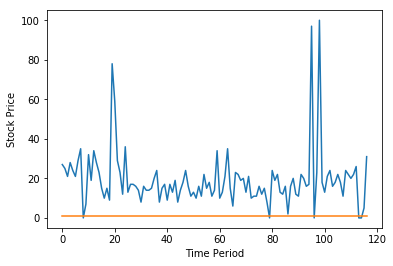

[step: 0] loss: 461856.5
[step: 1] loss: 459796.0
[step: 2] loss: 457900.28125
[step: 3] loss: 456387.53125
[step: 4] loss: 455423.15625
[step: 5] loss: 454808.53125
[step: 6] loss: 454391.0625
[step: 7] loss: 454092.90625
[step: 8] loss: 453870.0
[step: 9] loss: 453690.59375
[step: 10] loss: 453534.71875
[step: 11] loss: 453391.34375
[step: 12] loss: 453255.53125
[step: 13] loss: 453125.375
[step: 14] loss: 452997.03125
[step: 15] loss: 452863.71875
[step: 16] loss: 452718.96875
[step: 17] loss: 452563.5
[step: 18] loss: 452414.53125
[step: 19] loss: 452300.40625
[step: 20] loss: 452234.125
[step: 21] loss: 452200.40625
[step: 22] loss: 452180.78125
[step: 23] loss: 452166.28125
[step: 24] loss: 452154.03125
[step: 25] loss: 452143.78125
[step: 26] loss: 452136.8125
[step: 27] loss: 452132.34375
[step: 28] loss: 452129.71875
[step: 29] loss: 452128.25
[step: 30] loss: 452127.5
[step: 31] loss: 452127.09375
[step: 32] loss: 452126.84375
[step: 33] loss: 452126.65625
[step: 34] loss: 45

[step: 292] loss: 452124.0625
[step: 293] loss: 452124.0625
[step: 294] loss: 452124.0625
[step: 295] loss: 452124.0625
[step: 296] loss: 452124.0625
[step: 297] loss: 452124.0625
[step: 298] loss: 452124.0625
[step: 299] loss: 452124.0625
[step: 300] loss: 452124.0625
[step: 301] loss: 452124.0625
[step: 302] loss: 452124.0625
[step: 303] loss: 452124.0625
[step: 304] loss: 452124.0625
[step: 305] loss: 452124.0625
[step: 306] loss: 452124.0625
[step: 307] loss: 452124.0625
[step: 308] loss: 452124.0625
[step: 309] loss: 452124.0625
[step: 310] loss: 452124.0625
[step: 311] loss: 452124.0625
[step: 312] loss: 452124.0625
[step: 313] loss: 452124.0625
[step: 314] loss: 452124.0625
[step: 315] loss: 452124.0625
[step: 316] loss: 452124.0625
[step: 317] loss: 452124.0625
[step: 318] loss: 452124.0625
[step: 319] loss: 452124.0625
[step: 320] loss: 452124.0625
[step: 321] loss: 452124.0625
[step: 322] loss: 452124.0625
[step: 323] loss: 452124.0625
[step: 324] loss: 452124.0625
[step: 325

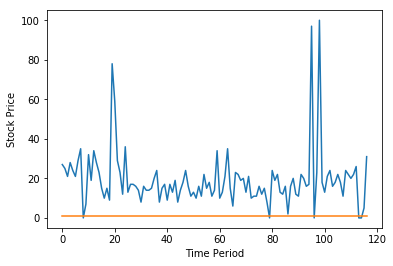

In [22]:
#train parameters
seq_length=7
data_dim=4
hidden_dim=10
output_dim=1
learning_rate=0.01
iterations=500
#기본형식
#기본 인자로는 ds-y로 받고 
#처리함수에서 ds를 받아서 'feature 처리모듈'에서 ds에서 요일(주중, 주말), 월(계절) + 날씨와 같은 추가 요인-값을 받는다.


x=xy
y=xy[:,[-1]]

#build a dataset
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length):
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]
    print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)

# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

#input place holders
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, 1])
# build a LSTM network(input: cell shape, type/ )
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# use the last cell's output to calculate Y_pred
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=tf.tanh) 
# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()
